In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/MyDrive/attention_flow

/content/gdrive/MyDrive/attention_flow


In [3]:
!ls

attention_graph_util.py		 graphs			 res_fat_bert.png
bert_example.ipynb		 __pycache__		 res_jat_bert_att_2.png
bert_sv.ipynb			 rat_bert_att_2.png	 res_jat_bert.png
bert_viz.ipynb			 rat_bert_bar_2.png	 res_rat_bert_mrpc.pdf
compute_corel_distilbert_sst.py  rat_bert_mrpc.pdf	 res_rat_bert.png
correlation_logs		 rat_bert.png		 run_bert_sv.py
distilbert_sst.ipynb		 README.md		 save
distill_bert_viz.ipynb		 res_fat_bert_att_2.png  utils


In [8]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from attention_graph_util import *
import seaborn as sns
import itertools
import matplotlib as mpl
import networkx as nx
import os
from utils import constants

from absl import app
from absl import flags
import pandas as pd

# from util.models import MODELS
# from util.tasks import TASKS
#from dnotebook_utils import *
from attention_graph_util import *
%matplotlib inline
# from utils.config_util import get_task_params
# from notebooks.notebook_utils import *
from utils import inflect

from tqdm import tqdm
from scipy.stats import spearmanr
import math


rc={'font.size': 10, 'axes.labelsize': 10, 'legend.fontsize': 10.0,
    'axes.titlesize': 32, 'xtick.labelsize': 20, 'ytick.labelsize': 16}
plt.rcParams.update(**rc)
mpl.rcParams['axes.linewidth'] = .5 #set the value globally

import torch
from transformers import *
from transformers import BertConfig, BertForMaskedLM, BertTokenizer
from transformers import DistilBertTokenizer, DistilBertModel
import torch

import numpy as np
import tensorflow_datasets as tfds
from attention_graph_util import *

import matplotlib as mpl

mpl.rcParams['axes.linewidth'] = 0.0 #set the value globally


GroupViT models are not usable since `tensorflow_probability` can't be loaded. It seems you have `tensorflow_probability` installed with the wrong tensorflow version.Please try to reinstall it following the instructions here: https://github.com/tensorflow/probability.
TAPAS models are not usable since `tensorflow_probability` can't be loaded. It seems you have `tensorflow_probability` installed with the wrong tensorflow version. Please try to reinstall it following the instructions here: https://github.com/tensorflow/probability.


In [9]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForMaskedLM.from_pretrained('distilbert-base-uncased',
                                        output_hidden_states=True,
                                        output_attentions=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/12040accade4e8a0f71eabdb258fecc2e7e948be/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/12040accade4e8a0f71eabdb258fecc2e7e948be/tokenizer_config.json
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/12040accade4e8a0f71eabdb258fecc2e7e948be/tokenizer.json
loading file chat_template.jinja from cache at None


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/12040accade4e8a0f71eabdb258fecc2e7e948be/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.48.3",
  "vocab_size": 30522
}

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/12040accade4e8a0f71eabdb258fecc2e7e948be/config.json
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBer

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/12040accade4e8a0f71eabdb258fecc2e7e948be/model.safetensors
All model checkpoint weights were used when initializing DistilBertForMaskedLM.

All the weights of DistilBertForMaskedLM were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use DistilBertForMaskedLM for predictions without further training.


In [10]:
sentence = "He said his last words"
sentence = "James Cook was a nice person and a good husband"
sentence = "The horse raced past the barn fell"
tokens = ['cls']+tokenizer.tokenize(sentence)+['sep']
print(len(tokens))
print(tokens)
input_ids = torch.tensor([tokenizer.encode(sentence)])
all_hidden_states, all_attentions = model(input_ids)[-2:]

_attentions = [att.detach().numpy() for att in all_attentions]
attentions_mat = np.asarray(_attentions)[:,0]
print(attentions_mat.shape)

DistilBertSdpaAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


9
['cls', 'the', 'horse', 'raced', 'past', 'the', 'barn', 'fell', 'sep']
(6, 12, 9, 9)


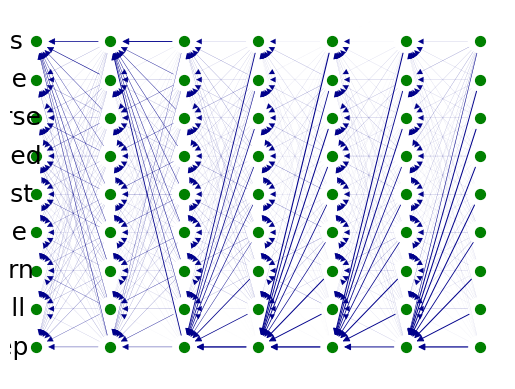

In [11]:
att_mat = attentions_mat.sum(axis=1)/attentions_mat.shape[1]
adj_mat, labels_to_index = get_adjmat(mat=att_mat, input_tokens=tokens)

G = draw_attention_graph(adj_mat,labels_to_index, n_layers=attentions_mat.shape[0], length=attentions_mat.shape[-1])
plt.savefig('rat_distillbert.png', format='png', transparent=True, dpi=760)

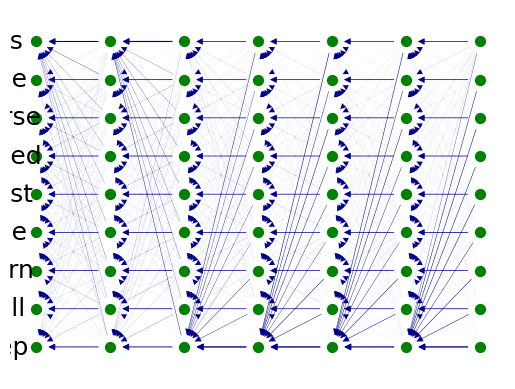

In [12]:
res_att_mat = attentions_mat.sum(axis=1)/12
res_att_mat = res_att_mat + np.eye(res_att_mat.shape[1])[None,...]
res_att_mat = res_att_mat / res_att_mat.sum(axis=-1)[...,None]

res_adj_mat, res_labels_to_index = get_adjmat(mat=res_att_mat, input_tokens=tokens)

res_G = draw_attention_graph(res_adj_mat,res_labels_to_index, n_layers=res_att_mat.shape[0], length=res_att_mat.shape[-1])
plt.savefig('res_rat_distillbert.png', format='png', transparent=True, dpi=760)

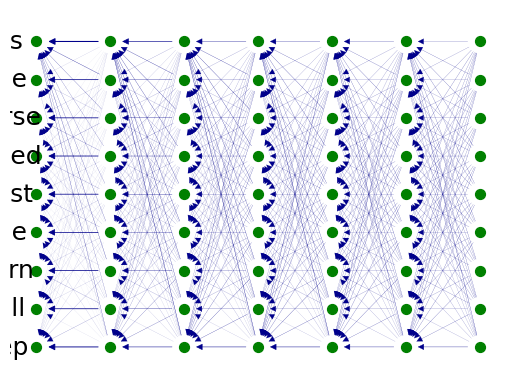

In [13]:
output_nodes = []
input_nodes = []
for key in labels_to_index:
    if 'L6' in key:
        output_nodes.append(key)
    if labels_to_index[key] < attentions_mat.shape[-1]:
        input_nodes.append(key)

flow_values = compute_flows(res_G, res_labels_to_index, input_nodes, length=attentions_mat.shape[-1])

flow_G = draw_attention_graph(flow_values,labels_to_index, n_layers=attentions_mat.shape[0], length=attentions_mat.shape[-1])
plt.savefig('res_fat_bert.png', format='png', transparent=True, dpi=760)

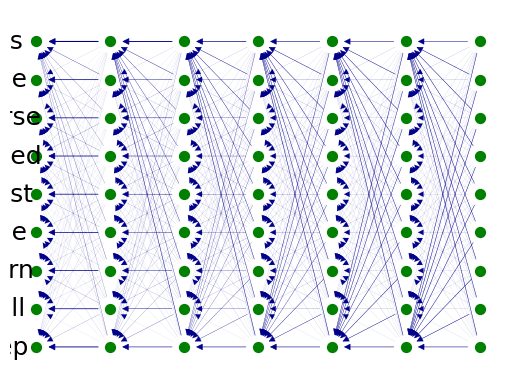

In [14]:
joint_attentions = compute_joint_attention(res_att_mat, add_residual=False)
joint_att_adjmat, joint_labels_to_index = get_adjmat(mat=joint_attentions, input_tokens=tokens)

G = draw_attention_graph(joint_att_adjmat,joint_labels_to_index, n_layers=joint_attentions.shape[0], length=joint_attentions.shape[-1])
plt.savefig('res_jat_distillbert.png', format='png', transparent=True, dpi=760)

In [15]:
data = tfds.load('glue/mrpc')

# Prepare dataset for GLUE as a tf.data.Dataset instance
train_dataset = glue_convert_examples_to_features(data['train'], tokenizer, max_length=128, task='mrpc')
valid_dataset = glue_convert_examples_to_features(data['validation'], tokenizer, max_length=128, task='mrpc')
train_dataset = train_dataset.shuffle(100).batch(32).repeat(10)
valid_dataset = valid_dataset.batch(64)

valid_iter = iter(valid_dataset)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3668 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/glue/mrpc/incomplete.NY5JXF_2.0.0/glue-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/408 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/glue/mrpc/incomplete.NY5JXF_2.0.0/glue-validation.tfrecord*...:   0%|     …

Generating test examples...:   0%|          | 0/1725 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/glue/mrpc/incomplete.NY5JXF_2.0.0/glue-test.tfrecord*...:   0%|          |…

Dataset glue downloaded and prepared to /root/tensorflow_datasets/glue/mrpc/2.0.0. Subsequent calls will reuse this data.


/usr/local/lib/python3.11/dist-packages/transformers/data/processors/glue.py:66: FutureWarning: This function will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("function"), FutureWarning)
/usr/local/lib/python3.11/dist-packages/transformers/data/processors/glue.py:174: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
Using label list ['0', '1'] for task mrpc
Using output mode classification for task mrpc
*** Example ***
guid: 1680

In [17]:
data = tfds.load('glue/sst2')

# Prepare dataset for GLUE as a tf.data.Dataset instance
train_dataset = glue_convert_examples_to_features(data['train'], tokenizer, max_length=128, task='sst-2')
valid_dataset = glue_convert_examples_to_features(data['validation'], tokenizer, max_length=128, task='sst-2')
train_dataset = train_dataset.shuffle(100).batch(32).repeat(10)
valid_dataset = valid_dataset.batch(64)

valid_iter = iter(valid_dataset)

/usr/local/lib/python3.11/dist-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
Using label list ['0', '1'] for task sst-2
Using output mode classification for task sst-2
*** Example ***
guid: 16399
features: InputFeatures(input_ids=[101, 2005, 1996, 4895, 5498, 10711, 3064, 3248, 2488, 2006, 2678, 2007, 1996, 2614, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [18]:
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')

# Prepare training: Compile tf.keras model with optimizer, loss and learning rate schedule
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# Train and evaluate using tf.keras.Model.fit()
history = model.fit(train_dataset, epochs=10, steps_per_epoch=115,
                    validation_data=valid_dataset, validation_steps=7)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.48.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/model.safetensors
Loaded 109,482,240 parameters in the TF 2.0 model.
All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
115/115 [==============================] - 152s 794ms/step - loss: 0.3916 - accuracy: 0.8201 - val_loss: 0.2492 - val_accuracy: 0.8951
Epoch 2/10
115/115 [==============================] - 89s 776ms/step - loss: 0.2869 - accuracy: 0.8859 - val_loss: 0.2309 - val_accuracy: 0.9241
Epoch 3/10
115/115 [==============================] - 88s 769ms/step - loss: 0.2481 - accuracy: 0.9019 - val_loss: 0.2722 - val_accuracy: 0.8929
Epoch 4/10
115/115 [==============================] - 91s 787ms/step - loss: 0.2187 - accuracy: 0.9144 - val_loss: 0.2317 - val_accuracy: 0.9085
Epoch 5/10
115/115 [==============================] - 91s 789ms/step - loss: 0.2148 - accuracy: 0.9187 - val_loss: 0.2380 - val_accuracy: 0.9107
Epoch 6/10
115/115 [==============================] - 89s 777ms/step - loss: 0.1977 - accuracy: 0.9231 - val_loss: 0.2239 - val_accuracy: 0.9107
Epoch 7/10
115/115 [==============================] - 89s 776ms/step - loss: 0.2157 - accuracy: 0.9168 - val_loss: 0.1948 - val_a

In [23]:
x,y = valid_iter.next()
print(x['input_ids'][0])


tf.Tensor(
[  101  1037  3643  3238 25358  2666  6643 11219  2000  4013  3455  2104
 15773  2011  1996  6452  1012   102     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0], shape=(128,), dtype=int32)
tf.Tensor(
[  101  6097  3527  4381  1010  3005 15536  6199  2100  2670 11084  2038
 14453  9442  3821  1012  1012  1012  7545  2019  7078 15544 19510  2075
 10652  2000  2014  2535

In [20]:
# Load the TensorFlow model in PyTorch for inspection
model.save_pretrained('save/')


Configuration saved in save/config.json
Model weights saved in save/tf_model.h5


In [21]:
pytorch_model = BertForSequenceClassification.from_pretrained('save/', from_tf=True, output_hidden_states=True,
                                    output_attentions=True)

loading configuration file save/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_attentions": true,
  "output_hidden_states": true,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.48.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file save/tf_model.h5
Loading TensorFlow weights from save/tf_model.h5
All TF 2.0 model weights were used when initializing BertForSequenceClassification.

All the weights of BertForSequenceClassification

In [ ]:
# Quickly test a few predictions - MRPC is a paraphrasing task, let's see if our model learned the task
sentence_0 = "This research was consistent with his findings."
sentence_1 = "His findings were compatible with this research."
sentence_2 = "His findings were not consistent with this research."
inputs_1 = tokenizer.encode_plus(sentence_0, sentence_1, add_special_tokens=True, return_tensors='pt')
inputs_2 = tokenizer.encode_plus(sentence_0, sentence_2, add_special_tokens=True, return_tensors='pt')

pred_1 = pytorch_model(inputs_1['input_ids'], token_type_ids=inputs_1['token_type_ids'])[0].argmax().item()
pred_2 = pytorch_model(inputs_2['input_ids'], token_type_ids=inputs_2['token_type_ids'])[0].argmax().item()

print("sentence_1 is", "a paraphrase" if pred_1 else "not a paraphrase", "of sentence_0")
print("sentence_2 is", "a paraphrase" if pred_2 else "not a paraphrase", "of sentence_0")

In [27]:
sentence_0 = "I saw the trailer peeking through the window"

sentence_0 = "This is a good pie"
sentence_1 = "This is tasty"
sentence_1 = "It tastes good"
sentence_2 = "this cake tastes bad"

sentence_0 = "I saw it peeking through the window"
sentence_1 = "I was peeking when I saw it"
sentence_2 = "It was peeking through the window"


tokens_1 = ['cls']+tokenizer.tokenize(sentence_0)+['sep']+tokenizer.tokenize(sentence_1)+['sep']
print(len(tokens_1))
inputs_1 = tokenizer.encode_plus(sentence_0, sentence_1, add_special_tokens=True, return_tensors='pt')

tokens_2 = ['cls']+tokenizer.tokenize(sentence_0)+['sep']+tokenizer.tokenize(sentence_2)+['sep']
print(len(tokens_1))
inputs_2 = tokenizer.encode_plus(sentence_0, sentence_2, add_special_tokens=True, return_tensors='pt')

outputs_1 = pytorch_model(inputs_1['input_ids']) #, token_type_ids=inputs_1['token_type_ids'])
pred_1 = outputs_1[0].argmax().item()
print("prediction:", bool(pred_1))

outputs_2 = pytorch_model(inputs_2['input_ids']) #, token_type_ids=inputs_2['token_type_ids'])
pred_2 = outputs_2[0].argmax().item()
print("prediction:", bool(pred_2))

all_hidden_states, all_attentions = outputs_1[-2:]
_attentions = [att.detach().numpy() for att in all_attentions]
attentions_mat = np.asarray(_attentions)[:,0]
print(attentions_mat.shape)

17
17
prediction: False
prediction: False
(12, 12, 17, 17)


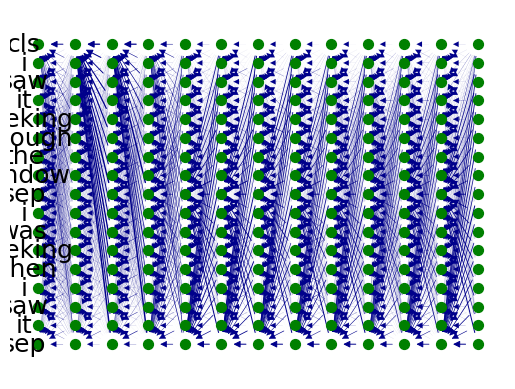

In [28]:
att_mat = attentions_mat.sum(axis=1)/8
adj_mat, labels_to_index = get_adjmat(mat=att_mat, input_tokens=tokens_1)

G = draw_attention_graph(adj_mat,labels_to_index, n_layers=attentions_mat.shape[0], length=attentions_mat.shape[-1])
plt.margins(0.06)
plt.savefig('rat_bert_mrpc.pdf', format='pdf', transparent=True, dpi=360)

In [29]:
att_mat[-1][0]

array([0.05264271, 0.03645822, 0.07572886, 0.13141999, 0.07147294,
       0.02667204, 0.041867  , 0.08896943, 0.26276237, 0.05530236,
       0.04425513, 0.06232621, 0.0460722 , 0.05326801, 0.06768196,
       0.12036525, 0.2627353 ], dtype=float32)

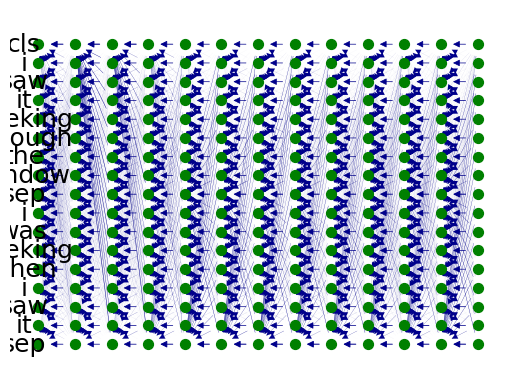

In [30]:
res_att_mat = attentions_mat.sum(axis=1)/12
res_att_mat = res_att_mat + np.eye(res_att_mat.shape[1])[None,...]
res_att_mat = res_att_mat / res_att_mat.sum(axis=-1)[...,None]

res_adj_mat, res_labels_to_index = get_adjmat(mat=res_att_mat, input_tokens=tokens_1)

res_G = draw_attention_graph(res_adj_mat,res_labels_to_index, n_layers=res_att_mat.shape[0], length=res_att_mat.shape[-1])
plt.margins(0.06)
plt.savefig('res_rat_bert_mrpc.pdf', format='pdf', transparent=True, dpi=360)

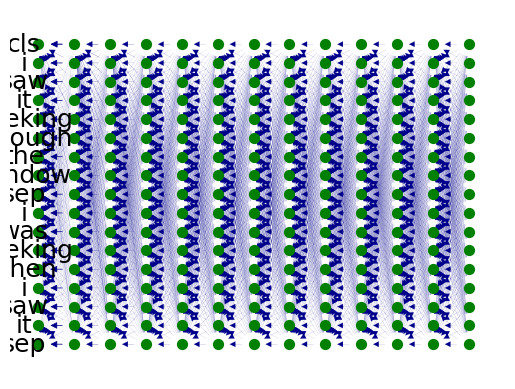

In [31]:
output_nodes = []
input_nodes = []
for key in labels_to_index:
    if 'L6' in key:
        output_nodes.append(key)
    if res_labels_to_index[key] < attentions_mat.shape[-1]:
        input_nodes.append(key)

flow_values = compute_flows(res_G, res_labels_to_index, input_nodes, length=attentions_mat.shape[-1])
plt.margins(0.06)
flow_G = draw_attention_graph(flow_values,res_labels_to_index, n_layers=attentions_mat.shape[0], length=attentions_mat.shape[-1])
plt.savefig('res_fat_bert_mrpc.pdf', format='pdf', transparent=True, dpi=360)

In [32]:
l = 14
d = 12
flow_values[d*l:, (d-1)*l: d*l][0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

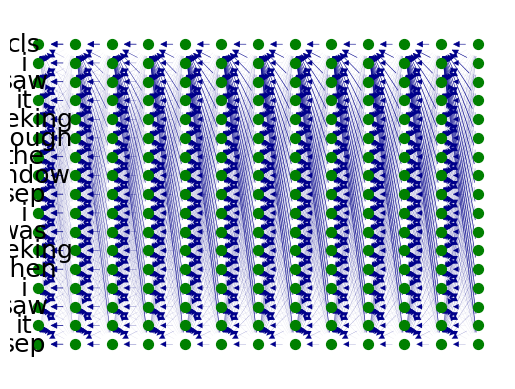

In [33]:
joint_attentions = compute_joint_attention(res_att_mat, add_residual=False)
joint_att_adjmat, joint_labels_to_index = get_adjmat(mat=joint_attentions, input_tokens=tokens_1)

plt.margins(0.06)
G = draw_attention_graph(joint_att_adjmat,joint_labels_to_index, n_layers=joint_attentions.shape[0], length=joint_attentions.shape[-1])
plt.savefig('res_jat_bert_mrpc.pdf', format='pdf', transparent=True, dpi=360)

In [34]:
joint_attentions[-1][0]

array([0.42322595, 0.02275794, 0.02243086, 0.021742  , 0.02846603,
       0.02195829, 0.04999516, 0.02966792, 0.10888381, 0.0246924 ,
       0.01951064, 0.02665188, 0.02664743, 0.02071882, 0.02290059,
       0.02583058, 0.10391969])

In [35]:
tfds.list_builders()

['abstract_reasoning',
 'accentdb',
 'aeslc',
 'aflw2k3d',
 'ag_news_subset',
 'ai2_arc',
 'ai2_arc_with_ir',
 'ai2dcaption',
 'aloha_mobile',
 'amazon_us_reviews',
 'anli',
 'answer_equivalence',
 'arc',
 'asqa',
 'asset',
 'assin2',
 'asu_table_top_converted_externally_to_rlds',
 'austin_buds_dataset_converted_externally_to_rlds',
 'austin_sailor_dataset_converted_externally_to_rlds',
 'austin_sirius_dataset_converted_externally_to_rlds',
 'bair_robot_pushing_small',
 'bc_z',
 'bccd',
 'beans',
 'bee_dataset',
 'beir',
 'berkeley_autolab_ur5',
 'berkeley_cable_routing',
 'berkeley_fanuc_manipulation',
 'berkeley_gnm_cory_hall',
 'berkeley_gnm_recon',
 'berkeley_gnm_sac_son',
 'berkeley_mvp_converted_externally_to_rlds',
 'berkeley_rpt_converted_externally_to_rlds',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist',
 'binary_alpha_digits',
 'ble_wind_field',
 'blimp',
 'booksum',
 'bool_q',
 'bot_adversarial_dialogue',
 'bridge',
 'bridge_data_msr',
 'bucc',
 'c4',
 'c4_ws

In [36]:
for x,y in zip(tokens_1, joint_attentions[-1][0]):
    print("("+x+","+str(y)+")")

','.join(tokens_1)

(cls,0.4232259454958733)
(i,0.022757937347105593)
(saw,0.02243086430170297)
(it,0.021741996667651888)
(peeking,0.028466031257267203)
(through,0.021958292150564267)
(the,0.04999516114513135)
(window,0.02966791924730767)
(sep,0.1088838137286958)
(i,0.024692400545242733)
(was,0.019510635619319767)
(peeking,0.026651878579666874)
(when,0.026647433291282514)
(i,0.020718821318464538)
(saw,0.022900591429575692)
(it,0.02583058324721799)
(sep,0.10391969462792995)


'cls,i,saw,it,peeking,through,the,window,sep,i,was,peeking,when,i,saw,it,sep'

In [37]:
for x,y in zip(tokens_1, att_mat[-1][0]):
    print("("+x+","+str(y)+")")

','.join(tokens_1)

(cls,0.052642714)
(i,0.036458217)
(saw,0.07572886)
(it,0.13141999)
(peeking,0.071472935)
(through,0.026672037)
(the,0.041867)
(window,0.08896943)
(sep,0.26276237)
(i,0.055302363)
(was,0.044255134)
(peeking,0.06232621)
(when,0.046072204)
(i,0.05326801)
(saw,0.06768196)
(it,0.120365255)
(sep,0.2627353)


'cls,i,saw,it,peeking,through,the,window,sep,i,was,peeking,when,i,saw,it,sep'

In [38]:
l = 14
d = 12
for x,y in zip(tokens_1,flow_values[d*l:, (d-1)*l: d*l][0]):
    print("("+x+","+str(y)+")")

','.join(tokens_1)

(cls,0.0)
(i,0.0)
(saw,0.0)
(it,0.0)
(peeking,0.0)
(through,0.0)
(the,0.0)
(window,0.0)
(sep,0.0)
(i,0.0)
(was,0.0)
(peeking,0.0)
(when,0.0)
(i,0.0)


'cls,i,saw,it,peeking,through,the,window,sep,i,was,peeking,when,i,saw,it,sep'